In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
cd /notebooks/

/notebooks


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from tqdm.notebook import trange, tqdm
from digital_twin_library import SubsetSampler, corr
import seaborn as sns
from neuralpredictors.data.datasets import FileTreeDataset
from neuralpredictors.measures.modules import PoissonLoss
from torch.utils.data import DataLoader
from digital_twin_library import *
from torch.optim.lr_scheduler import ReduceLROnPlateau

from neuralpredictors.data.transforms import (
    ToTensor,
    NeuroNormalizer,
    ScaleInputs,
)
from neuralpredictors.data.samplers import RepeatsBatchSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Configure the dataset, samplers and loaders

In [4]:
root_dir = 'data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
dat = FileTreeDataset(root_dir, 'images', 'responses')

transforms = [ScaleInputs(scale=0.25), ToTensor(torch.cuda.is_available())]
transforms.insert(0, NeuroNormalizer(dat))
dat.transforms.extend(transforms)

test_sampler = RepeatsBatchSampler(dat.trial_info.frame_image_id, np.where(dat.trial_info.tiers == 'test')[0])

test_loader = DataLoader(dat, batch_sampler=test_sampler)

# Compute oracle

In [5]:
for x, y in test_loader:
    print(x.shape, y.shape)
    x = x.detach().cpu().numpy()
    print(np.abs(np.diff(x, axis=0)).max())
    break

torch.Size([10, 1, 36, 64]) torch.Size([10, 8372])
0.0


In [15]:
responses, oracle_predictor = [], []
for _, y in test_loader:
    y = y.detach().cpu().numpy()
    responses.append(y)
    n = y.shape[0]
    trial_oracle = (n * np.mean(y, axis=0, keepdims=True) - y) / (n - 1)
    oracle_predictor.append(trial_oracle)
    
responses = np.vstack(responses)
oracle_predictor = np.vstack(oracle_predictor)

(998, 8372)


In [20]:
oracle_correlation = corr(responses, oracle_predictor, dim=0)

Load the model from storage

In [26]:
model = ConvModel(layers=3, input_kern=11, hidden_kern=5, hidden_channels=32, output_dim=8372)
state_dict = torch.load('models/model.pt')
model.load_state_dict(state_dict)
model.to(device)

with torch.no_grad():
    test_corrs = get_correlations(model, test_loader)


Plot the correlations

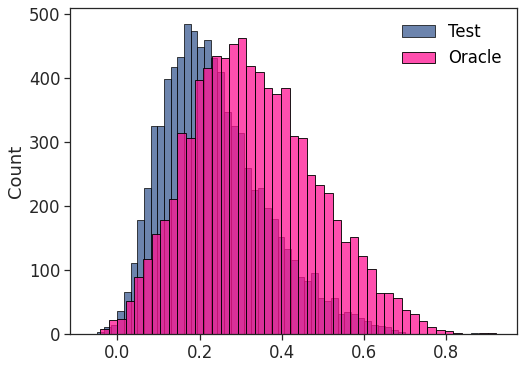

In [28]:
sns.set_context('notebook', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(test_corrs, kde=False, ax = ax, color=sns.xkcd_rgb['denim blue'], label='Test')
sns.histplot(oracle_correlation, kde=False, ax = ax, color='deeppink', label='Oracle')
ax.legend(frameon=False)


[Text(0.5, 0, 'Oracle correlation'),
 Text(0, 0.5, 'Model correlation'),
 (0.0, 1.0),
 (0.0, 1.0),
 None]

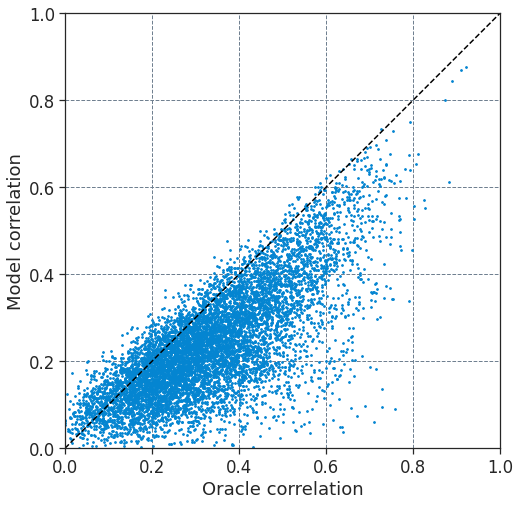

In [31]:
sns.set_context('notebook', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(oracle_correlation, test_corrs, s=3, color=sns.xkcd_rgb['cerulean'])
ax.grid(True, linestyle='--', color='slategray')
ax.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.set(
    xlabel='Oracle correlation',
    ylabel='Model correlation',
    xlim=[0, 1],
    ylim=[0, 1],
    aspect='equal',
)


# Correlation to average

In [32]:
avg_responses, model_predictor = [], []
for x, y in test_loader:
    y = y.detach().cpu().numpy()
    yhat = model(x).detach().cpu().numpy()
    avg_responses.append(y.mean(axis=0))
    model_predictor.append(yhat.mean(axis=0))
    
avg_responses = np.vstack(avg_responses)
model_predictor = np.vstack(model_predictor)
corr2avg = corr(avg_responses, model_predictor, dim=0)

(100, 8372) (100, 8372) (8372,)


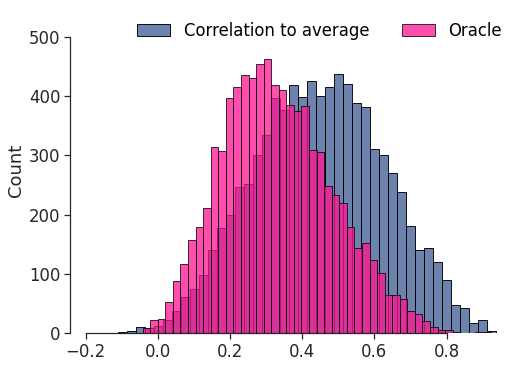

In [40]:
sns.set_context('notebook', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(corr2avg, kde=False, ax = ax, color=sns.xkcd_rgb['denim blue'], label='Correlation to average')
sns.histplot(oracle_correlation, kde=False, ax = ax, color='deeppink', label='Oracle')
ax.legend(frameon=False, ncol=2)
ax.set(
    ylim = [0, 550],
    xlabel='Correlation',
)
sns.despine(trim=True)